In [1]:
### Implementation of Random Forest Bagging classifier with hyper-parameter tuning.
### Data : All 7 folders.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm, tree
import xgboost
import os
import csv
from sklearn.model_selection import train_test_split
import seaborn as sns
#------------------
from scipy import fft, arange, signal

In [3]:
folder_root = "../../data/"

In [4]:
def find_files(PATH):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if '.csv' in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [5]:
def list_dir_files(root):
    """
    Finds all the files in a nested directory of folders and files (.csv)
    """
    files = []
    friendly_name = []
    for x in os.listdir(root):
        subfolder = root + x
        if os.path.isdir(subfolder):
            onfo = find_files(subfolder)
            if(len(onfo) > 0 and len(x.split("_")) > 1):##Removes test folder and empty folders
                files.append(onfo)
                fn = x.split("/")[-1]
                friendly_name.append(fn)
    return files, friendly_name

In [7]:
files, friendly_name = list_dir_files(folder_root)

In [11]:
files[1][-1]

'../../data/1_Fear/xxh1_31.12.19_19.00.10.bp.csv'

In [7]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        rd = rows[0].split(",")[3:8]
        rdt = []
        for x in rd:
            rdt.append(float(x))
        row_data.append(rdt)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [8]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return np.array(raw_data), dataframes

In [9]:
def root_subfolder_file_data(root_list):
    """
    Extracts dataframe and np.array() of each file within each subfolder of the root folder.
    Returns:
    1. n(n will increase)x5(m varies) dataframe
    2. n(n will increase)x5(m varies) np.array()
    """
    root_df = []
    root_np = []
    for x in root_list:
        rnd, rdf = data_DF_dir(x)
        root_df.append(rdf)
        root_np.append(rnd)
    return np.array(root_np), root_df

In [10]:
_, raw_df = root_subfolder_file_data(files)

In [11]:
raw_df[0][0].head() ## Anger 0th file

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4
0,4216.410156,4259.487305,4187.179688,4088.205078,4203.589844
1,4217.948730,4253.846191,4182.051270,4098.974121,4209.230957
2,4211.794922,4252.307617,4165.128418,4102.051270,4214.871582
3,4216.410156,4252.820313,4158.974121,4105.128418,4223.077148
4,4231.794922,4253.333496,4165.641113,4108.717773,4227.692383


In [12]:
def merge_all_data(dataframe, friendly_name, merge_name):
    """
    Merges all dataframes into one dataframe with associated emotion tag.
    """
    list_df_append_emotion = []
    for x,fn in zip(dataframe, friendly_name):
        for fil in x:
            holder = np.full((1, fil.shape[0]), float(fn.split("_")[0])).T
            temp_df = fil
            temp_df[merge_name] = holder
            list_df_append_emotion.append(temp_df)
    pd_df = list_df_append_emotion[0]
    for i in range(1, len(list_df_append_emotion)):
        pd_df = pd_df.append(list_df_append_emotion[i])
    pd_df = pd_df.reset_index().drop(['index'],axis=1)
    return pd_df

In [13]:
df = merge_all_data(raw_df, friendly_name, "emotion")

In [14]:
df.describe()

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,emotion
count,127854.000000,127854.000000,127854.000000,127854.000000,127854.000000,127854.000000
mean,4216.289048,4308.102057,4144.195051,4134.251142,4196.718927,3.609695
std,216.826926,144.389754,133.071393,137.035810,161.069711,2.806785
min,1529.743530,2809.743652,2167.179443,2592.307617,1709.230713,0.000000
25%,4177.948730,4246.025635,4096.410156,4106.153809,4162.051270,1.000000
50%,4221.538574,4308.931397,4146.153809,4137.948730,4197.948730,3.000000
75%,4263.077148,4369.743652,4192.820313,4168.205078,4234.358887,6.000000
max,8006.666504,5584.615234,6380.000000,6132.820313,6887.692383,8.000000


In [15]:
### Looks good. Data all merged. @ 11:47 am

In [16]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape ### Data split.

((102283, 5), (102283,), (25571, 5), (25571,))

In [19]:
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
# model2 = svm.SVC()
# classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5 = AdaBoostClassifier()
classifiers.append(model5)
model6 = GradientBoostingClassifier()
classifiers.append(model6)

In [20]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s\n"%(type(clf), acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is \n%s\n"%(type(clf), cm))

Accuracy of <class 'xgboost.sklearn.XGBClassifier'> is 0.5880489617144421

Confusion Matrix of <class 'xgboost.sklearn.XGBClassifier'> is 
[[1295 1022  103  512  199  308  592]
 [ 100 3014    4  122   48  359  329]
 [ 206  470  526  607   39  102  381]
 [ 185  694   83 2567   56  159  486]
 [ 133  118   19  104 1783   43  112]
 [  27   80    1   31    6 3684   97]
 [ 209 1345   59  349  220  415 2168]]

Accuracy of <class 'sklearn.tree.tree.DecisionTreeClassifier'> is 0.6180829846310273

Confusion Matrix of <class 'sklearn.tree.tree.DecisionTreeClassifier'> is 
[[2245  415  268  345  179  130  449]
 [ 439 2047  211  341   73  197  668]
 [ 243  186 1308  250   58   39  247]
 [ 364  320  305 2727   72   71  371]
 [ 168   71   49   60 1760   19  185]
 [ 150  234   42   70   20 3171  239]
 [ 469  699  269  381  202  198 2547]]



C:\Users\qasim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of <class 'sklearn.ensemble.forest.RandomForestClassifier'> is 0.6996597708341481

Confusion Matrix of <class 'sklearn.ensemble.forest.RandomForestClassifier'> is 
[[2620  462  127  270   96  131  325]
 [ 366 2713   69  148   41  216  423]
 [ 221  245 1391  216   30   41  187]
 [ 320  387  185 2986   36   65  251]
 [ 150   66   30   57 1900   22   87]
 [  96  125    9   28    3 3561  104]
 [ 396  830  141  284  154  240 2720]]

Accuracy of <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> is 0.48480700793868053

Confusion Matrix of <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> is 
[[ 549 1194  166  677  476  513  456]
 [  48 2968    2  154   59  367  378]
 [ 175  562  154  855   88  188  309]
 [ 281  887  134 1981  189  322  436]
 [  71  278    7   86 1701   98   71]
 [   3  156    1   41    6 3676   43]
 [ 224 1604   65  508  448  548 1368]]

Accuracy of <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> is 0.6071721872433616



In [21]:
### From the results, the highest accuracy score was that of Random Forest Classifier ~67.25%
results = model4.predict(X[20000:30000])

In [22]:
results = list(results)
print("Class 0 result : " + str(results.count(0)), "\nClass 1 result : " + str(results.count(1)))

Class 0 result : 312 
Class 1 result : 9209


In [23]:
### Hyper-parameter tuning

In [24]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  6.0min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [26]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
       learning_rate=0.15, max_delta_step=0, max_depth=10,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [27]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 10,
 'learning_rate': 0.15,
 'gamma': 0.4,
 'colsample_bytree': 0.7}

In [28]:
best_XGB = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [29]:
best_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [30]:
y_pred = best_XGB.predict(X_test)

In [31]:
print(accuracy_score(y_test, y_pred))

0.6826092057408784


In [32]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(best_XGB,X_test,y_test,cv=10)
print(score)
print("\n")
print(score.mean())

[0.64740336 0.63266901 0.63682565 0.65989054 0.65285379 0.64059445
 0.64931507 0.64618395 0.64931507 0.64892368]


0.6463974561637347


In [33]:
### Wow.. After hyper-parameter tuning, xgboost accuracy increased from 56.9% to 67.2%!!!

In [34]:
### Implementation of Random Forest w/ hyper-parameter tuning:

In [35]:
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 10,
                                  max_depth = 15, 
                                  min_samples_split = 5,  min_samples_leaf = 1, criterion='entropy') 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

In [36]:
model4

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
forestVC

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [38]:
accuracy_score(y_test, y_predVC) #68.09436

0.6837433029603848

In [39]:
params={
 "n_estimators"          : [10,50,100,200,250,500] ,
 "criterion"             : ['gini','entropy'],
 "max_leaf_nodes"        : [ None, 3, 5, 7, 10],
 "min_impurity_decrease" : [0.0,0.05,0.1,0.2],
 "min_samples_split"     : [0.5,2,3,4,5],   
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
classifier=RandomForestClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=15,n_jobs=-1,cv=15,verbose=3)
random_search.fit(X_train,y_train)

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 26.7min finished


RandomizedSearchCV(cv=15, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=15, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100, 200, 250, 500], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [None, 3, 5, 7, 10], 'min_impurity_decrease': [0.0, 0.05, 0.1, 0.2], 'min_samples_split': [0.5, 2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [41]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
random_search.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': None,
 'criterion': 'entropy'}

In [43]:
random_search.best_score_

0.7267874426835349

In [44]:
random_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
random_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_pred = random_best.predict(X_test)

In [47]:
print(accuracy_score(y_test, y_pred)) ## accuracy increased to 71.3%!!!

0.7276602401157561


In [48]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(random_best,X_test,y_test,cv=10)
print(score)
print("\n")
print(score.mean())

[0.67903163 0.66549433 0.65598124 0.6825645  0.67787334 0.66914353
 0.67084149 0.67710372 0.67279843 0.67162427]


0.6722456473036449


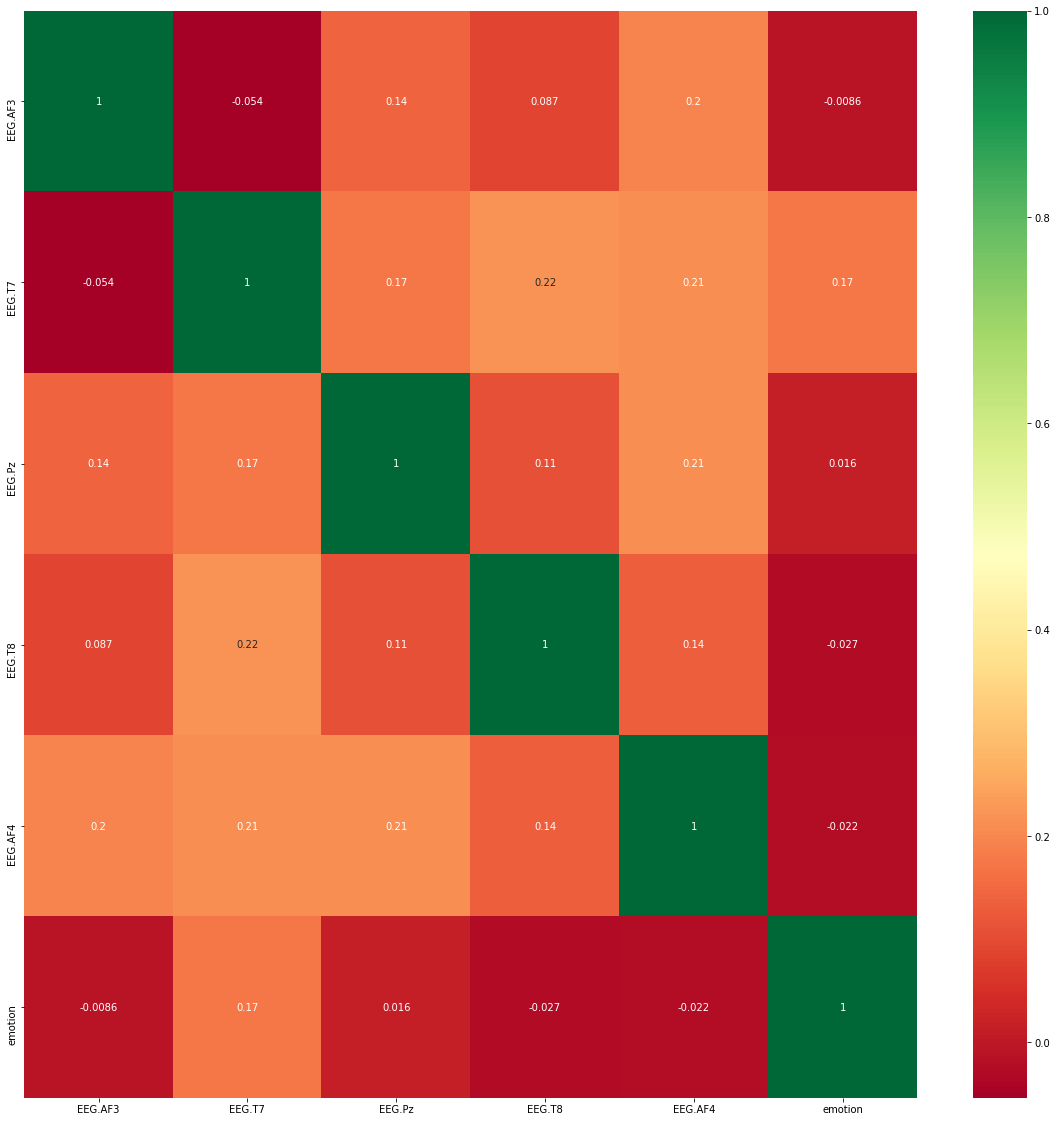

In [49]:
## Correlation
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [50]:
### Now, time to validate with real world test data.

In [51]:
test_folder = find_files(folder_root + "Test")

In [52]:
test_data, test_df = data_DF_dir(test_folder)

In [53]:
## data structure : 0,1 -> Anger ; 2,3 -> Happy

In [54]:
def run_test(results, friendly_name):
    for x in friendly_name:
        fn = x.split("_")
        print(fn[1] + " Count : " + str(test_results.count(int(fn[0]))))

In [80]:
test_results = list(random_best.predict(test_data[0]))
run_test(test_results, friendly_name)

Anger Count : 707
Fear Count : 404
Disgust Count : 150
Happiness Count : 873
Sadness Count : 27
Neutral Count : 354
Love Count : 246


In [70]:
#Fear works...
# Reflection... need same video.

In [71]:
test_folder

['../../data/Test/d0_28.12.19_16.01.33.bp.csv',
 '../../data/Test/fear0_28.12.19_13.44.00.bp.csv',
 '../../data/Test/h0_28.12.19_15.22.43.bp.csv',
 '../../data/Test/lo_28.12.19_15.15.18.bp.csv',
 '../../data/Test/lv_test1_28.12.19_15.26.03.bp.csv',
 '../../data/Test/n0_28.12.19_13.38.29.bp.csv',
 '../../data/Test/n1_28.12.19_13.39.14.bp.csv',
 '../../data/Test/sad0_28.12.19_15.18.44.bp.csv']

In [58]:
test_data[0][0:-1]

array([[4308.205078, 4353.846191, 4171.794922, 4099.487305, 4271.794922],
       [4289.743652, 4360.512695, 4171.282227, 4083.076904, 4267.692383],
       [4282.05127 , 4322.05127 , 4144.102539, 4076.923096, 4252.307617],
       ...,
       [4957.94873 , 4405.641113, 4214.871582, 4274.871582, 5130.769043],
       [4948.205078, 4408.205078, 4218.461426, 4270.769043, 5128.205078],
       [4939.487305, 4409.230957, 4202.563965, 4257.94873 , 5108.205078]])

In [59]:
### Implementation of results using keras w/ tensorflow backend

In [60]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [61]:
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [62]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
102283/102283 [==============================] - 24s 230us/step - loss: -971513443.9994 - accuracy: 0.1553
Epoch 2/150
102283/102283 [==============================] - 24s 238us/step - loss: -9905622796.0173 - accuracy: 0.1553
Epoch 3/150
102283/102283 [==============================] - 26s 257us/step - loss: -35282449829.5431 - accuracy: 0.1553
Epoch 4/150
102283/102283 [==============================] - 26s 254us/step - loss: -84780620639.1612 - accuracy: 0.1553
Epoch 5/150
102283/102283 [==============================] - 25s 246us/step - loss: -166139192892.8372 - accuracy: 0.1553s - l
Epoch 6/150
102283/102283 [==============================] - 26s 250us/step - loss: -286451217834.1960 - accuracy: 0.1553
Epoch 7/150
102283/102283 [==============================] - 27s 266us/step - loss: -453714126998.2842 - accuracy: 0.1553
Epoch 8/150
102283/102283 [==============================] - 25s 245us/step - loss: -675313373872.8445 - accuracy: 0.1553
Epoch 9/150
102283/102283 

102283/102283 [==============================] - 22s 214us/step - loss: -2676048249134737.0000 - accuracy: 0.1553
Epoch 131/150
102283/102283 [==============================] - 24s 236us/step - loss: -2737991460315764.5000 - accuracy: 0.1553
Epoch 132/150
102283/102283 [==============================] - 25s 243us/step - loss: -2800999451239045.5000 - accuracy: 0.1553
Epoch 133/150
102283/102283 [==============================] - 26s 250us/step - loss: -2864914202247831.5000 - accuracy: 0.1553
Epoch 134/150
102283/102283 [==============================] - 26s 251us/step - loss: -2929671145246559.5000 - accuracy: 0.1553
Epoch 135/150
102283/102283 [==============================] - 27s 260us/step - loss: -2995549887462280.5000 - accuracy: 0.1553
Epoch 136/150
102283/102283 [==============================] - 28s 269us/step - loss: -3062289139223941.5000 - accuracy: 0.1553
Epoch 137/150
102283/102283 [==============================] - 26s 259us/step - loss: -3130107375201529.5000 - accurac

In [64]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

102283/102283 [==============================] - 1s 14us/step
Accuracy: 15.53


In [65]:
res_keras = model.predict(test_data[5])

In [66]:
run_test(res_keras, friendly_name)

Anger Count : 445
Fear Count : 1343
Disgust Count : 103
Happiness Count : 550
Sadness Count : 5
Neutral Count : 22
Love Count : 1096


In [67]:
test_folder

['../../data/Test/d0_28.12.19_16.01.33.bp.csv',
 '../../data/Test/fear0_28.12.19_13.44.00.bp.csv',
 '../../data/Test/h0_28.12.19_15.22.43.bp.csv',
 '../../data/Test/lo_28.12.19_15.15.18.bp.csv',
 '../../data/Test/lv_test1_28.12.19_15.26.03.bp.csv',
 '../../data/Test/n0_28.12.19_13.38.29.bp.csv',
 '../../data/Test/n1_28.12.19_13.39.14.bp.csv',
 '../../data/Test/sad0_28.12.19_15.18.44.bp.csv']

In [68]:
### Reflection : DL activation f(x) sigmoid, relu accuracy 16.61%. epochs set to 150.
### Reflection : ML gradient boosting the best algorithm with parameter tuning.